In [76]:
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from IPython.display import Image, display
from ipywidgets import HBox, Image as WidgetImage, Layout
import pandas as pd

#### IT3105 – Artificial Intelligence Programming; Introductory Project
# General Purpose JAX-based PID Controllers
##### Sindre Grodås Standal Aas og Elias Lerheim Birkeland

________

## Controller Class
The Controller class should take the error –– from running one time step –– as input, and then output a controll signal.
The error consists of the current difference between target state and actual state, the sum of all previous errors of the time steps in one epoch, and the change in error from last time step.

In [77]:
def display_images(filenames):
    widgets = []
    # Load images as widgets
   
    for images in filenames:
        image = WidgetImage(value=open(images, 'rb').read(), format='jpeg', width=700)
        widgets.append(image)

    # Display images side by side using HBox
    display(HBox(widgets))
display_images(['standard_PID.jpeg', 'nn_PID.jpeg'])

In [78]:
class Controller:
    def __init__(self):
        pass

    def controll_signal(self, current_E, sum_E, dE):
        pass

    def update(self):
        pass

In [79]:
class StandardController(Controller):
    def __init__(self, k_p=0.1, k_i=0.3, k_d=0.1):
        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d
        super().__init__()

    def output_U(self, E, sum_E, dE):
        return self.k_p * E + self.k_d * dE + self.k_i * sum_E

## Plant Class
In each time step, a plant should take the controll signal from a controller as input –– either neural network based or standard controller –– and then return its updated state, which is some distance from the target state.

In [80]:
class Plant:
    def __init__(self):
        pass

    def output_Y(self, controll_signal):
        pass

In [81]:
class BathtubPlant:
    def __init__(self, area_A=100.0, initial_height_H=10.0, g=9.81):
        self.g = g
        self.initial_height_H = initial_height_H
        self.area_A = area_A
        self.height_H = initial_height_H
        self.cross_section_C = self.area_A / 100
        self.velocity_V = np.sqrt(2 * self.g * self.height_H)
        self.flow_rate_Q = self.velocity_V * self.cross_section_C
        super().__init__()

    def change_in_volume(self, output_U, noise_D):
        return output_U + noise_D - self.flow_rate_Q

    def output_Y(self, output_U, noise_D):
        self.height_H += self.change_in_volume(output_U, noise_D) / self.area_A
        return self.height_H

    def resetPlant(self):
        self.height_H = self.initial_height_H
        self.velocity_V = np.sqrt(2 * self.g * self.height_H)
        return

In [82]:
class CournotPlant:

    def __init__(self, pmax, marginal_cost, initial_q1=0.1, initial_q2=0.1, goal_profit = 0.5):
        self.pmax = pmax
        self.goal_profit = goal_profit
        self.profit = 0.0
        self.marginal_cost = marginal_cost
        self.initial_q1 = initial_q1
        self.initial_q2 = initial_q2
        self.q1 = initial_q1
        self.initial_q2 = initial_q2
        super().__init__()

    def Q(self,q1,q2):
        return q1 + q2
    
    def P(self, q1, q2):
        return self.pmax - self.Q(q1,q2)
    
    def update_q(self, output_U, noise_D):
        self.q1 += output_U
        self.q2 += noise_D
        self.profit = self.q1 * (self.P(self.q1,self.q2)-self.marginal_cost) 
        return
    
    def output_Y(self):
        self.profit = self.q1 * (self.P(self.q1,self.q2)-self.marginal_cost)
        return self.profit
    
    def resetPlant(self):
        self.q1 = self.initial_q1
        self.q2 = self.initial_q2
        return

    


    

## System Configuration

### Pivotal Parameters

In [83]:
display_images(['pivotal_params.jpeg'])

In [84]:
PLANT = 'cournot' # {'bathtub', 'cournot', 'rabbit'}
NN_BASED = False # {True -> neural network based controller, False -> standard controller}
NUM_LAYERS = 1 # Number of layers in the neural network –– between 0 and 5 hidden layers
NUM_NEURONS = [] # Number of neurons in each layer
ACTIVATION_FUNC = None
WEIGHTS_BIAS_RANGE = None
NUM_EPOCHS = 100
NUM_TIMESTEPS = 100
LEARNING_RATE = 0.001
DISTURBANCE_RANGE = [-0.01,0.01]
A = 100.0 # C follows from A
H0 = 10.0
PMAX = 1.0
MC = 0.1

INITIAL_Q1 = 0.1
INITIAL_Q2 = 0.1
GOAL_PROFIT= 0.5

In [85]:
class Consys:
    def __init__(self, num_epochs=NUM_EPOCHS, num_timesteps=NUM_TIMESTEPS, learning_rate=LEARNING_RATE, 
                 noise_min=DISTURBANCE_RANGE[0], noise_max=DISTURBANCE_RANGE[1], controller_type_is_nn=NN_BASED):
        
        self.controller_type_is_nn = controller_type_is_nn

        if controller_type_is_nn:
            self.controller = NeuralController()
            self.params = self.controller.init(jax.random.PRNGKey(0), jnp.zeros((1, 3)))['params']
            self.optimizer = optax.adam(learning_rate)
            self.opt_state = self.optimizer.init(self.params)

        else:
            self.controller = StandardController()

        if PLANT == 'cournot':
            self.plant = CournotPlant(pmax=PMAX, marginal_cost=MC, initial_q1=INITIAL_Q1, initial_q2=INITIAL_Q2, goal_profit=GOAL_PROFIT,)
        
        elif PLANT == 'rabbits':
            self.plant = RabbitsPlant()

        else:
            self.plant = BathtubPlant(area_A=A, initial_height_H=H0)

        self.num_epochs = num_epochs
        self.num_timesteps = num_timesteps
        self.learning_rate = learning_rate
        self.noise_min = noise_min
        self.noise_max = noise_max
        self.error_history = []

    def run_epoch(self, params=None, pid_weights=None):
        if not self.controller_type_is_nn:
            self.controller.k_p, self.controller.k_i, self.controller.k_d = pid_weights

        self.plant.resetPlant()
        integral_sum = 0.0
        prev_error = None
        error_history = []

        for i in range(self.num_timesteps):

            if PLANT == 'bathtub':
                current_error = self.plant.initial_height_H - self.plant.height_H
                error_history.append(current_error)
                integral_sum += current_error
                derivative = 0.0 if prev_error is None else current_error - prev_error
                inputs = jnp.array([current_error, integral_sum, derivative]).reshape(1, -1)

                if self.controller_type_is_nn:
                    U = self.controller.apply({'params': params}, inputs).squeeze()
                else:
                    U = self.controller.output_U(current_error, integral_sum, derivative)
                
                noise = np.random.uniform(self.noise_min, self.noise_max)
                self.plant.output_Y(U, noise)
                prev_error = current_error

            else:
                current_error = self.plant.profit - self.plant.goal_profit
                error_history.append(current_error)
                integral_sum += current_error
                derivative = 0.0 if prev_error is None else current_error - prev_error
                inputs = jnp.array([current_error, integral_sum, derivative]).reshape(1, -1)

                if self.controller_type_is_nn:
                    U = self.controller.apply({'params': params}, inputs).squeeze()
                else:
                    U = self.controller.output_U(current_error, integral_sum, derivative)

                noise = np.random.uniform(self.noise_min, self.noise_max)
                #self.plant.update_q(U, noise)
                prev_error = current_error

        mse = jnp.mean(jnp.array(error_history) ** 2)  # Use jnp instead of np
        return mse


    def simulate_epochs(self):
        mse_history = []
        pid_history = []

        if self.controller_type_is_nn:
            for epoch in range(self.num_epochs):
                loss = self.run_epoch(params=self.params)
                mse_history.append(loss)

                grads = jax.grad(self.run_epoch, argnums=0)(self.params)
                updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
                self.params = optax.apply_updates(self.params, updates)
            return mse_history
        
        else:
            pid_params = jnp.array([self.controller.k_p, self.controller.k_i, self.controller.k_d])

            for epoch in range(self.num_epochs):
                # Define a function that computes MSE given PID parameters
                def compute_mse(params):
                    kp, ki, kd = params  # Unpack the JAX array to individual PID parameters
                    # Call run_epoch with unpacked PID parameters wrapped in a tuple
                    return self.run_epoch(pid_weights=(kp, ki, kd))

                # Compute loss and gradients
                mse, grads = jax.value_and_grad(compute_mse)(pid_params)
                mse_history.append(mse.item())  # Convert JAX array to scalar and append to mse_history

                # Apply gradients to PID parameters
                pid_params -= self.learning_rate * grads

                # Update the controller's PID parameters with new values
                self.controller.k_p, self.controller.k_i, self.controller.k_d = pid_params

                # Convert updated PID parameters to list for history tracking
                pid_history.append(pid_params.tolist())

            return mse_history, pid_history

______

## Bathtub System with Standard PID Controller

In [86]:
system = Consys()

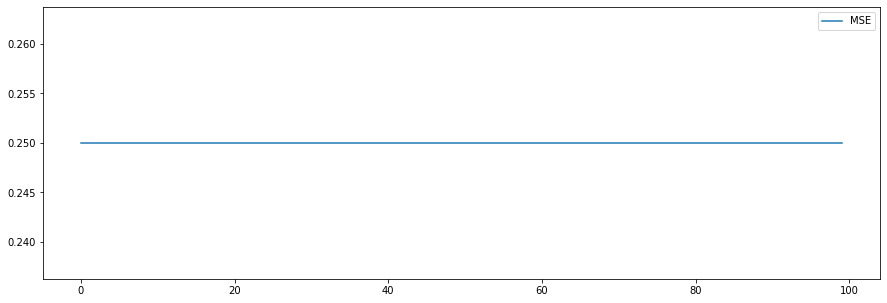

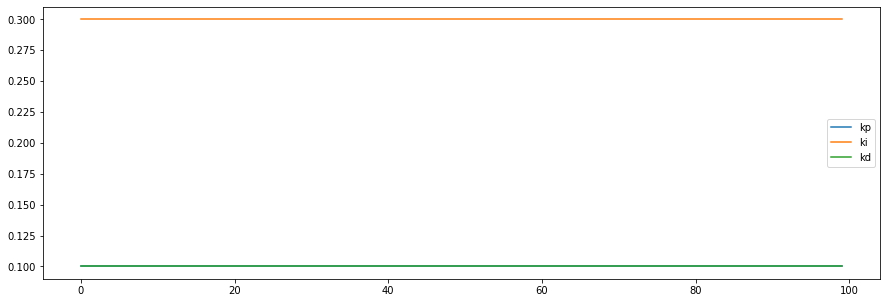

In [87]:
if system.controller_type_is_nn:
    mse_history = system.simulate_epochs()
    mse_df = pd.DataFrame([mse.item() for mse in mse_history])

    mse_df.plot(figsize=(15,5))
else:
    mse_history, pid_history = system.simulate_epochs()

    mse_df = pd.DataFrame({'MSE': mse_history})
    pid_df = pd.DataFrame([list(map(float, pid)) for pid in pid_history], columns=['kp', 'ki', 'kd'])
    
    mse_df.plot(figsize=(15,5))
    pid_df.plot(y=['kp','ki','kd'], figsize=(15,5))
